# 3. color GAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/GAN/Ch3-GAN.ipynb)

2장에서는 Victorain400 데이터셋의 이미지를 폴더별로 시각화 해보았습니다. 3장에서는 본격적으로 GAN을 이용하여 흑백 이미지를 컬러 이미지로 변환시키는 모델을 구축해보도록 하겠습니다.


3.1절에서는 모델링에 사용할 데이터를 불러오고, 3.2절에서는 데이터셋 클래스를 정의하여 데이터 로더까지 정의하도록 하겠습니다. 3.3절에서는 Generator 클래스와 Discriminator 클래스를 정의하여 모델을 구축해보겠습니다. 그리고 3.4절에서는 하이퍼파라미터를 설정하여 구축된 모델을 학습시킨 후, 3.5절에서 테스트 데이터에 대한 예측과 성능평가를 해보도록 하겠습니다.

## 3.1 데이터셋 다운로드

2.1절에서 나온 코드를 활용하여 모델에 사용할 데이터셋을 내려받도록 하겠습니다. 가짜연구소 깃허브의 Tutorial-Book-Utils를 `clone`하고 PL_data_loader.py 파일로 Victorian400 데이터셋을 내려받아 압축을 푸는 순서입니다.

In [34]:
%pip install chardet

In [35]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


^C


'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


이번에는 3장에서 사용할 패키지들을 불러오겠습니다. `os`와 `glob`는 파일 경로를 지정할 수 있는 패키지이며, `datetime`은 날짜, 시간을 계산할 수 있는 패키지입니다. 그리고 `numpy`는 수치 연산에 사용되는 선형 대수 패키지이며, `matplotlib`과 `PIL`의 `Image`는 이미지 파일을 시각화하는데 사용하는 패키지입니다. 그 외의 `torch`와 `torchvision` 패키지는 데이터셋 정의와 모델 구축에 사용되는 Torch 기반의 패키지들입니다.

In [44]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## 3.2 데이터셋 클래스 정의

파이토치 모델에 데이터를 학습하기 위해서 데이터셋 클래스를 정의해보도록 하겠습니다. 흑백, 컬러 이미지의 폴더 경로와 이미지 변환(transforms)을 인자로 받아 `Image.open` 함수를 사용하여 해당 이미지를 불러옵니다. 흑백 이미지는 `.convert("L")`을 사용하여 단일 채널로, 컬러 이미지는 `.convert("RGB")`을 사용하여 3채널로 받아줍니다. 그리고 이미지 변환을 거쳐 딕셔너리 형태로 흑백 이미지와 컬러 이미지를 "A", "B"에 각각 반환시켜줍니다.

In [54]:
class VictorianDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):

        self.color_transforms = transforms.Compose(color_transforms_)
        self.gray_transforms = transforms.Compose(gray_transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'color') + "/*.*"))

    def __getitem__(self, index):

        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("L")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")

        gray_img = self.gray_transforms(gray_img)
        color_img = self.color_transforms(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)


이미지 경로와 사이즈, 각 데이터셋의 배치사이즈를 지정해줍니다. 이미지 사이즈와 배치사이즈는 각자의 환경(최대 메모리 사용량)에 맞춰 설정해주면 됩니다. 단, 이후에 나올 모델 구조가 256으로 고정되어 있어 다른 이미지 사이즈를 원하실 경우 모델 구조도 약간의 수정이 필요합니다.

In [51]:
from pathlib import Path
root = Path('Data/')
mode = "Gear"
train_root = root / mode
test_root = root / mode / 'test/'

img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 6

gpu = 0

데이터셋 클래스의 인자로 넣을 이미지 변환(transform)을 지정합니다. 튜토리얼에서는 파이토치 모델에 넣기 위해 tensor 타입으로 바꿔주고 2.4절에서 구한 평균과 표준편차로 `normalize`를 해주도록 하겠습니다. 이 외에도 모델 구조에 따라 `Resize`를 해주거나, 도메인에 따라 `RandomCrop`(랜덤으로 자르기), `RandomVerticalFlip`(랜덤으로 수평 뒤집기) 등 다양한 이미지 변형을 할 수 있습니다.

In [52]:
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533]
gray_std = [0.25051587]

color_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

위에서 정의한 데이터셋 클래스와 이미지 변환(transform)을 `DataLoader`함수에 넣어줍니다.

In [55]:
train_loader = DataLoader(
    VictorianDataset(str(train_root), color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size,
    shuffle=True
)

데이터 로더가 제대로 구성되어 있는지 알아보기 위해 시각화해보겠습니다. 데이터 로더에는 정규화된 이미지가 저장되어 있기 때문에 정규화를 복원시키고 시각화해주어야 합니다. 따라서 `reNormalize`함수를 만들어 다시 표준편차를 곱하고 평균을 더해줍니다. 이때 `.transpose()`는 축의 순서를 바꿔주고 `.clip(min, max)`은 min보다 작으면 min으로, max보다 크면 max로 바꿔주는 역할을 합니다. 또한, "A"에 해당하는 흑백 이미지는 단일 채널이기 때문에 `.reshape()`을 통해 2차원으로 바꿔주고 `cmap=gray`를 설정해주어야 이미지를 제대로 출력할 수 있습니다.

In [56]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img

torch.Size([12, 3, 256, 256])


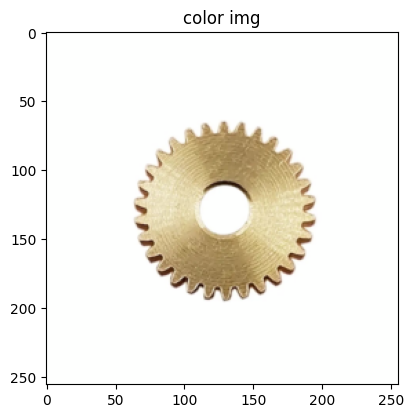

In [57]:
fig = plt.figure(figsize=(10,5))
rows = 1
cols = 2

for X in train_loader:

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap='gray')
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')

    plt.show()
    break

데이터 로더가 제대로 구성되어 흑백 이미지와 컬러 이미지가 잘 출력되고 있습니다. 마찬가지로 테스트 데이터 로더도 정의하고 시각화해보겠습니다.

In [59]:
test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

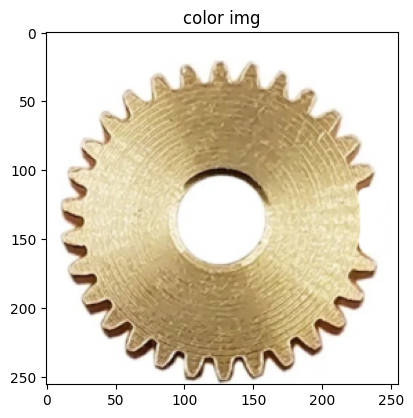

In [60]:
fig = plt.figure(figsize=(10,5))
rows = 1
cols = 2

for X in test_loader:

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap='gray')
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')

    plt.show()
    break

테스트 데이터 로더도 잘 구성된 것을 확인할 수 있습니다.

## 3.3 모델 구축

이번에는 데이터셋을 학습시킬 모델을 구축해보도록 하겠습니다. 3.3절에서는 GAN 모델을 사용하여 흑백 이미지를 컬러 이미지로 변환시켜볼 것 입니다. GAN 모델은 생성 모델(Generator)과 판별 모델(Discriminator)로 이루어져 있습니다. 각각은 `Conv2d`와 `ConvTranspose2d`, `MaxPool2d`, 정규화, 활성화함수들로 이루어져 있습니다.

In [62]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )

        self.maxpool = nn.MaxPool2d(2,2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1)
        )

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )


        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        output3 = self.upsample(output2) + output1
        output4 = self.conv1by1(output3)
        out = self.conv(output4)
        return out

In [63]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),

            )


        self.fc = nn.Sequential(
            nn.Linear(1024 * 8 * 8 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )

    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

학습시 배치마다 가중치를 초기화 시켜주어야 합니다. 따라서 `weights_init` 함수를 만들어 생성 모델(Generator)과 판별 모델(Discriminator)에 붙여줍니다.

In [64]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

그리고 생성 모델(Generator)과 판별 모델(Discriminator)을 GPU에서 학습시키기 위해 `.cuda(gpu)`를 통해 모델을 전달해줍니다. 이 때, `gpu`에는 위에서 지정한 device가 들어갑니다. 출력되는 것을 통해 모델 구조를 확인할 수 있습니다.

In [65]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negativ

In [66]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

## 3.4 모델 학습

이제 구축된 모델을 학습시켜보겠습니다. 학습 횟수는 50으로 지정하고, 생성모델과 판별모델 모두 Adam 최적화 방법을 사용해보겠습니다. 각 하이퍼파라미터는 튜닝하여 다양한 실험을 해볼 수 있습니다.

학습은 생성모델, 판별모델 순으로 진행됩니다. 생성모델에서는 판별모델을 속일 수 있는 컬러 이미지를 생성하도록 학습합니다. 그리고 판별모델에서는 컬러 이미지를 진짜(real)로, 흑백 이미지를 가짜(fake)로 인식하도록 학습합니다.

In [67]:
from pathlib import Path

checkpointSavePath = Path("checkpoints/")
os.makedirs(checkpointSavePath, exist_ok=True)

In [68]:
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [69]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [70]:
bestCheckpointsSavePath = checkpointSavePath / mode
eachCheckpointsSavePath = checkpointSavePath / mode / "each"

max_epoch = 200

best_loss = 10000
best_epoch = 0

for epoch in range(max_epoch):
    start_time = datetime.datetime.now()
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        grays, color = data['A'], data['B']
        b_size = len(data['A'])


        ######## 생성모델(Generator) 학습 ########
        ######## Train Generator ########
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
        gray_noise = Variable(torch.cat([grays,noise],dim=1)).to(device)
        fake_img = Gener(gray_noise)
        output = Discri(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)


        ######## 역전파 & 생성모델 최적화 ########
        ######## Backpropagation & Optimize G ########
        Discri.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()


        ######## 판별모델(Discriminator) 학습 ########
        ######## Train Discriminator ########
        color = Variable(color.to(device))
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
        gray_noise = Variable(torch.cat([grays,noise],dim=1)).to(device)


        ######## 판별모델이 컬러 이미지를 진짜(real)로 인식하도록 학습 ########
        ######## Train d to recognize color image as real ########
        output = Discri(color,b_size)
        real_loss = torch.mean((output-1)**2)


        ######## 판별모델이 흑백 이미지를 가짜(fake)로 인식하도록 학습 ########
        ######## Train d to recognize fake image as fake ########
        fake_img = Gener(gray_noise)
        output = Discri(fake_img,b_size)
        fake_loss = torch.mean(output**2)


        ######## 역전파 & 판별모델 최적화 ########
        ######## Backpropagation & Optimize D ########
        d_loss = real_loss + fake_loss
        Discri.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()


        fake_img = torchvision.utils.make_grid(fake_img.data)

        if d_loss < best_loss:
            best_epoch = epoch
            torch.save(Gener.state_dict(), str(bestCheckpointsSavePath / "generator_best.pth"))
            torch.save(Discri.state_dict(), str(bestCheckpointsSavePath / "discriminator_best.pth"))

    epoch_time = datetime.datetime.now() - start_time
    if (epoch + 1) % 5 == 0:
        torch.save(Gener.state_dict(), str(eachCheckpointsSavePath / "generator_{}.pth".format(epoch+1)))
        torch.save(Discri.state_dict(), str(eachCheckpointsSavePath / "discriminator_{}.pth".format(epoch+1)))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
        plt.imshow(reNormalize(fake_img.cpu(), color_mean, color_std))
        plt.show()

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[12, 4, 256, 256] to have 1 channels, but got 4 channels instead

5에폭마다 생성모델과 판별모델의 가중치를 저장하여 나중에 학습된 모델을 재구현할 수 있도록 합니다. 그리고 각 모델의 로스값과 생성모델에서 생성한 이미지를 출력하여 어떻게 학습되고 있는지 확인합니다.

생성모델의 로스와 판별모델의 로스의 관계를 확인하여 적절한 에폭 수를 결정하는 것이 중요합니다. 그렇지 못할 경우, 한 모델에 오버피팅되어 더 이상의 학습이 무의미해지게 됩니다.

## 3.5 예측 및 성능 평가

학습이 끝났으니 새로운 흑백 이미지에 적용하여 컬러 이미지로 예측(채색)해보도록 하겠습니다. 위에서 학습한 모델의 가중치를 불러오고 테스트 데이터 로더의 이미지를 넣어 예측하게 됩니다. 튜토리얼에서는 35에폭의 가중치를 불러오도록 하겠습니다. 이처럼 출력되는 이미지를 보면서 원하시는 에폭의 가중치를 불러와도 됩니다.

In [27]:
Gener.load_state_dict(torch.load(str(bestCheckpointsSavePath / "generator_best.pth") ))
Discri.load_state_dict(torch.load(str(bestCheckpointsSavePath / "discriminator_best.pth") ))

<All keys matched successfully>

==================input==================


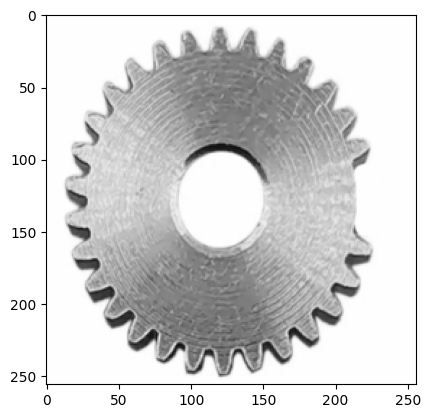

==================target==================


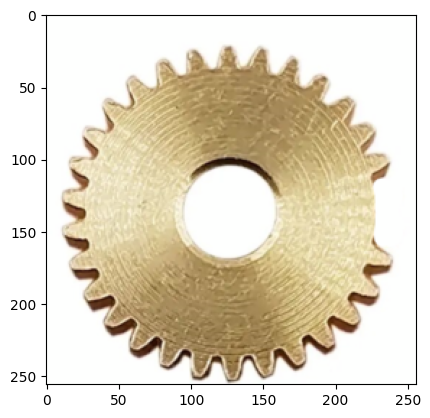

==================output==================


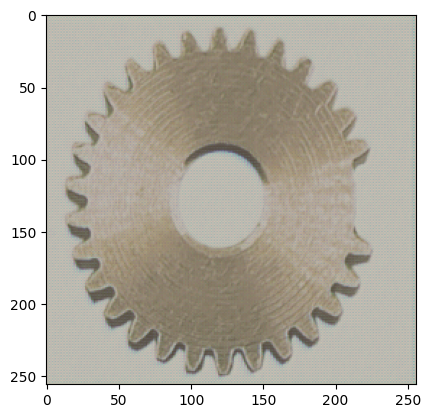

==================input==================


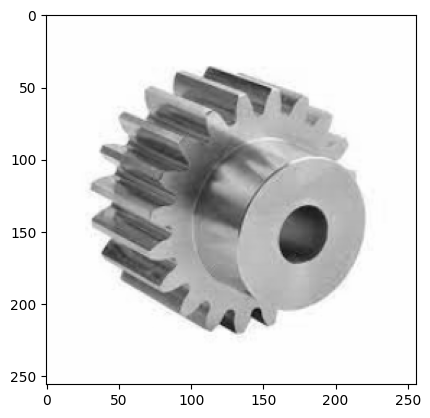

==================target==================


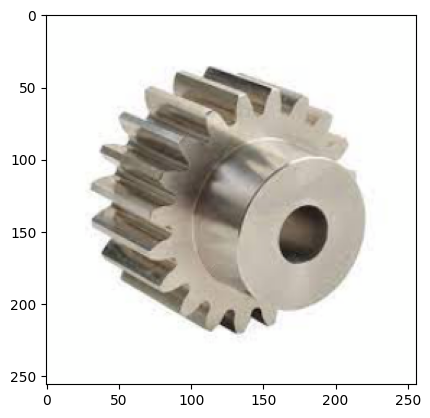

==================output==================


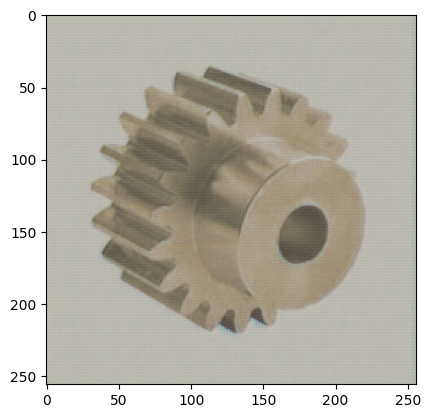

In [42]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, img_height, img_width)))
    gray = Variable(torch.cat([grays,fixed_noise],dim = 1).to(device))

    output = Gener(gray)

    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)

    print('==================input==================')
    plt.imshow(reNormalize(inputs.cpu(), gray_mean, gray_std))
    plt.show()
    print('==================target==================')
    plt.imshow(reNormalize(labels.cpu(), color_mean, color_std))
    plt.show()
    print('==================output==================')
    plt.imshow(reNormalize(out.cpu(), color_mean, color_std))
    plt.show()

결과는 흑백(input), 컬러(target), 생성된 이미지(output)순으로 출력되어집니다. 선명하진 않지만 비슷한 색감이 어느 정도 채색된 것을 볼 수 있습니다.

지금까지 3장에서 흑백 이미지를 컬러 이미지로 바꾸는 생성모델 GAN을 구축해보았습니다. 다음 장에서는 채색에 더 특화되어있는 pix2pix모델을 사용하여 비교해보도록 하겠습니다.

# Generative Model

## 1. Tensorflow

In [172]:
%pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/fb/59/3eb58629e3749d9f4fc1e522487af369f9bd4c451f465d3054961fab6bf8/tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5b/6f/8b125d126d54061c0be610b135aaf2f8960f55c2e185ac32445e4a5012d5/tensorflow-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/38/ba/dd4d998a852451e98dc009ecb208bbb0eeb0c8252dc35b7c4e1050762b36/tensorflow_intel-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.w

In [ ]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32   # 32x32 픽셀
channels =3 # rgb

"""생성자는 32부터 출발함 generator_input 계속 인풋으로 쓰임 (32,)로 스타트"""
generator_input = keras.Input(shape = (latent_dim,))


# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
"""16*16*128은 32,768로 32*32*3 = 3072보다 훨씬 크지만 우선 충분히 크게 만들고 나서 줄이려는듯??"""

x= layers.Dense(128*16*16)(generator_input) #완전연결로 쫙 일단 펴주는듯
"""위의 x에 리키렐루(음수약간 허용함:희소 gradient방지) go"""
x = layers.LeakyReLU()(x) 
x = layers.Reshape((16,16,128))(x) #다시 x를 [16,16,128]로 업데이트


# 합성곱 층을 추가합니다 [16x16x256] 유지됨 
""" cf.256은 필터(엣지)수 지정, !!이게 3텐서에 깔렸던듯!!"""
x = layers.Conv2D(256,5,padding = 'same')(x) 
"""5가 윈도우자리인데 뭘까? int로 쓰면 (5,5)로 알아서 되는듯!(help에 있음) +패딩해서 양끝 안 줄게 한다"""
x = layers.LeakyReLU()(x)


# 32 × 32 크기로 업샘플링합니다(전치 conv2d이용하면 늘어나나)
"""이거 거치면서 [32,32,256]됨 #전치행렬을 이용하여 filter들을 다시 모아주는듯? 자세한건 찾아보다 맘 (귀찮...)"""
""" '32 × 32' = 1024 = '256 * 4' 여서(??) 무관할수도 """
x = layers.Conv2DTranspose(256, 4, strides = 2, padding = 'same')(x)
#strides 2면 2칸씩 이동 이었던듯
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x) #5윈도우 이동시 4개빠지니 same pad.
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

#32x32 크기의 1개 채널을 가진 특성맵 생성(책서 3개 오탄가??)
"""활성화는 tanh이용함 (경험칙상 이게 낫다 위에 써있음)"""
x = layers.Conv2D(channels,7,activation = 'tanh',padding = 'same')(x)
##generator_input(32,) 부터 x 쫘라락해서 (32,32,3)까지
generator = keras.models.Model(generator_input, x)
generator.summary()

discriminator_input = layers.Input(shape=(height, width, channels))
x= layers.Conv2D(128,3)(discriminator_input) #128채널,(3,3)
x= layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x) #maxpooling대신에 strides로 반 정도 줄임
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)  #컨브넷 4개 거치면 2x2x128 (=512) 됨
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)  # 다 펴주니까 512개 됨

# 드롭아웃 층을 넣는 것이 아주 중요합니다!(노이즈 생성에서 멈추지 않도록)
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 그래디언트 클리핑: 기울기 폭주 방지 임계값서 자르는 것인듯..
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다(디폴트 0.001인가 그랬었지)
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


discriminator.trainable = True #판별자 가중치 학습 못하게

gan_input = keras.Input(shape=(latent_dim,)) #(32,)부터
gan_output = discriminator(generator(gan_input)) # Gan_func()= 판별자(생성자)
gan = keras.models.Model(gan_input,gan_output)

##기울기크리핑과 학습율 엄청낮춘 것
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

# CIFAR10 데이터를 로드합니다
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten()==6] 

print(x_train.shape) #개구리 5천마리 x 32x32x3 pixel
plt.imshow(x_train[0])

x_train = x_train.reshape( # """ 5000마리는 두고 나머지는 x/255. """
   (x_train.shape[0],)+(height,width,channels)).astype('float32') / 255.

iterations = 1000
batch_size = 20
save_dir = './datasets/gan_images/' #코랩시에는 경로 변경 必
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

with tf.device('/device:GPU:0'):
  start = 0
  for step in range(iterations):
      # 잠재 공간에서 무작위로 포인트를 샘플링합니다(정규분포로!!위에 설명중에 有)
      # (batch[20] X latent_dim[32]):위에서 계속 생성자는 latent_dim[32]부터 출발했음
      random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

      # 가짜 이미지를 디코딩합니다
      generated_images = generator.predict(random_latent_vectors)

      # 진짜 이미지와 연결합니다(진짜이미지는 걍 순차적으로: 개수는 똑같이 함(배치 만큼))
      stop = start + batch_size  #start에서 배치만큼 계속 더해감(뒤에서)
      real_images = x_train[start: stop]
      combined_images = np.concatenate([generated_images, real_images])

      # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
      # [32 x 1]차원 하나는 1행렬 하나는 0행렬  ==> [64X1] 행렬 됨
      # """왜 위가 1행렬이지..? 위가 생성자 이미지 인데? """
      # """ ans > 진짜가 0으로 해논듯 여긴..."""
      labels = np.concatenate([np.ones((batch_size, 1)),
                              np.zeros((batch_size, 1))])

      # """레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!"""
      # (위 모델 견고 방법중..(동적평형이니까 갇힐가능성 큼 !위험))
      #sol1. 판별자 드랍아웃 + sol2. 판별자 레이블에 랜덤노이즈
      # """전부에 0.05*(0~1랜덤 소수) 약 0.025씩 더해줘서 노이즈 생성 """
      labels += 0.05 * np.random.random(labels.shape)

      # discriminator를 훈련합니다(gan과 별개로 인듯)
      d_loss = discriminator.train_on_batch(combined_images, labels)

      #"""gan으로 생성자 훈련부분 : 생성자는 모두 진짜가 되게끔 하는게 목적"""
      #"""정답을 모두 0[여기서 정답]으로"""
      # 잠재 공간에서 무작위로 포인트를 샘플링합니다
      random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

      # """모두 '진짜 이미지'라고 레이블을 만듭니다"""
      misleading_targets = np.zeros((batch_size, 1))

      # 생성자(generator)를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
      a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
      
      start += batch_size
      if start > len(x_train) - batch_size: #위로 넘어가기전에 다시 0으로(진짜이미지)
        start = 0

      # 중간 중간 저장하고 그래프를 그립니다
      if step % 100 == 0:
          # 모델 가중치를 저장합니다
          gan.save_weights('gan.h5')

          # 측정 지표를 출력합니다
          print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
          print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

          # 생성된 이미지 하나를 저장합니다
          img = image.array_to_img(generated_images[0] * 255., scale=False)
          img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

          # 비교를 위해 진짜 이미지 하나를 저장합니다
          img = image.array_to_img(real_images[0] * 255., scale=False)
          img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

# 2. Torch

In [175]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [176]:
class VictorianDataset(Dataset):
    def __init__(self, root, transforms_=None):
        self.transforms = transforms.Compose(transforms_)

        self.color_files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
        color_img = self.transforms(color_img)

        return color_img

    def __len__(self):
        return len(self.color_files)


In [177]:
root = Path('Data')
mode = "Gear"
train_root = root / mode / 'train'
test_root = root / mode / 'test'

img_height = 256
img_width = 256

batch_size = 2
test_batch_size = 6

gpu = 0

In [178]:
train_mean = [0.58090717, 0.52688643, 0.45678478]
train_std = [0.25644188, 0.25482641, 0.24456465]

train_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
]

test_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
]

In [179]:
train_loader = DataLoader(
    VictorianDataset(str(train_root), transforms_=train_transforms_),
    batch_size=batch_size,
    shuffle=True
)

In [180]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img

torch.Size([2, 3, 256, 256])


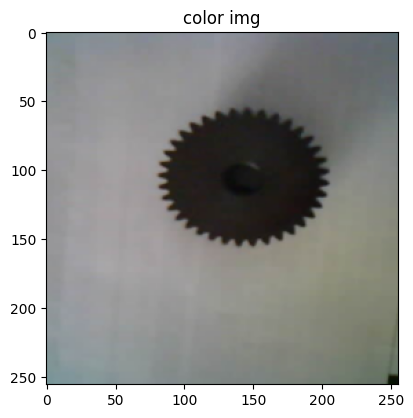

In [181]:
fig = plt.figure(figsize=(10,5))
rows = 1
cols = 2

for X in train_loader:
    print(X.shape)
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X[0], color_mean, color_std))
    ax2.set_title('color img')

    plt.show()
    break

In [182]:
test_loader = DataLoader(
    VictorianDataset(str(test_root), transforms_=test_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

torch.Size([2, 3, 256, 256])


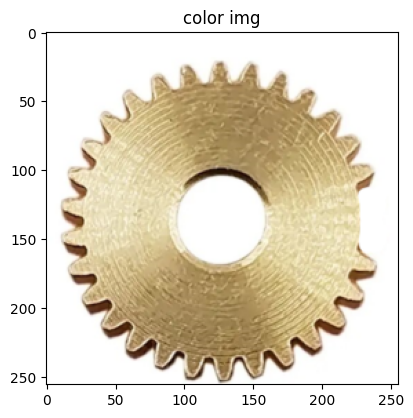

In [183]:
fig = plt.figure(figsize=(10,5))
rows = 1
cols = 2

for X in test_loader:
    print(X.shape)

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(X[0].numpy().transpose(1,2,0))
    ax2.set_title('color img')

    plt.show()
    break

In [184]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )

        self.maxpool = nn.MaxPool2d(2,2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 6 , 3, 1, 1),
            nn.BatchNorm2d(64 * 6),
            nn.LeakyReLU(0.1)
        )

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64 * 6, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )


        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        output3 = self.upsample(output2) + output1
        output4 = self.conv1by1(output3)
        out = self.conv(output4)
        return out

In [185]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),

            )


        self.fc = nn.Sequential(
            nn.Linear(1024 * 8 * 8 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )

    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

In [186]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [187]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

In [188]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

In [189]:
from pathlib import Path

checkpointSavePath = Path("checkpoints/")
os.makedirs(checkpointSavePath, exist_ok=True)

In [190]:
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [191]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [193]:
bestCheckpointsSavePath = checkpointSavePath / mode
eachCheckpointsSavePath = checkpointSavePath / mode / "each"

max_epoch = 200

best_loss = 10000
best_epoch = 0

for epoch in range(max_epoch):
    start_time = datetime.datetime.now()
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        color = data
        b_size = len(data)


        ######## 생성모델(Generator) 학습 ########
        ######## Train Generator ########
        noise = torch.randn(b_size, 3, img_height, img_width).uniform_(0,1)
        img_noise = Variable(torch.cat([color,noise],dim=1)).to(device)
        fake_img = Gener(img_noise)
        output = Discri(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)


        ######## 역전파 & 생성모델 최적화 ########
        ######## Backpropagation & Optimize G ########
        Discri.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()


        ######## 판별모델(Discriminator) 학습 ########
        ######## Train Discriminator ########
        color = Variable(color.to(device))
        noise = torch.randn(b_size, 3, img_height, img_width).uniform_(0,1)

        ######## 판별모델이 컬러 이미지를 진짜(real)로 인식하도록 학습 ########
        ######## Train d to recognize color image as real ########
        output = Discri(color,b_size)
        real_loss = torch.mean((output-1)**2)

        ######## 판별모델이 흑백 이미지를 가짜(fake)로 인식하도록 학습 ########
        ######## Train d to recognize fake image as fake ########
        fake_img = Gener(noise)
        output = Discri(fake_img,b_size)
        fake_loss = torch.mean(output**2)


        ######## 역전파 & 판별모델 최적화 ########
        ######## Backpropagation & Optimize D ########
        d_loss = real_loss + fake_loss
        Discri.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()


        fake_img = torchvision.utils.make_grid(fake_img.data)

        if d_loss < best_loss:
            best_epoch = epoch
            torch.save(Gener.state_dict(), str(bestCheckpointsSavePath / "generator_best.pth"))
            torch.save(Discri.state_dict(), str(bestCheckpointsSavePath / "discriminator_best.pth"))

    epoch_time = datetime.datetime.now() - start_time
    if (epoch + 1) % 5 == 0:
        torch.save(Gener.state_dict(), str(eachCheckpointsSavePath / "generator_{}.pth".format(epoch+1)))
        torch.save(Discri.state_dict(), str(eachCheckpointsSavePath / "discriminator_{}.pth".format(epoch+1)))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
        plt.imshow(reNormalize(fake_img.cpu(), color_mean, color_std))
        plt.show()

<string>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)


In [174]:
Gener.load_state_dict(torch.load(str(bestCheckpointsSavePath / "generator_best.pth") ))
Discri.load_state_dict(torch.load(str(bestCheckpointsSavePath / "discriminator_best.pth") ))

RuntimeError: Error(s) in loading state_dict for Discriminator:
	size mismatch for fc.4.weight: copying a param with shape torch.Size([12, 256]) from checkpoint, the shape in current model is torch.Size([2, 256]).
	size mismatch for fc.4.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([2]).

In [ ]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, img_height, img_width)))
    gray = Variable(torch.cat([grays,fixed_noise],dim = 1).to(device))

    output = Gener(gray)

    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)

    print('==================input==================')
    plt.imshow(reNormalize(inputs.cpu(), gray_mean, gray_std))
    plt.show()
    print('==================target==================')
    plt.imshow(reNormalize(labels.cpu(), color_mean, color_std))
    plt.show()
    print('==================output==================')
    plt.imshow(reNormalize(out.cpu(), color_mean, color_std))
    plt.show()